# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [3]:
# git config --global user.email "yl1127.pan@gmail.com"
# git config --global user.name "Yunlong"

In [4]:
# !pip install plotly
# conda install -c conda-forge matplotlib
# conda install -c conda-forge xarray dask netCDF4 bottleneck
# pip install torch
# conda install seaborn
# conda install scipy
# conda install -c conda-forge ipywidgets
# !pip install nbformat

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go


In [6]:
from src import (
    open_period,
    ensure_lat_lon_dims,
    subset_by_years,
    load_land_mask,
    CoraDataset,
    NeuralCoraCNN,
    fit,
    create_predictions,
    rename_for_score,
    compute_weighted_rmse,
)

from src.networks import (
    build_resnet,
    build_uresnet,
    build_unet,
    build_unet_google,
)


## Downloading the data

The data is hosted here. For this guide we will simply download the a year (1997) data.

In [7]:
# To do

## Open the data

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
import os

data_dir = "/home/yunlong/neuralcora-data"
DATA_DIR = data_dir
# List all files in the directory
datasets = [f for f in os.listdir(data_dir) if f.endswith(".nc")]
datasets.sort()  # sort for readability

print("Available datasets:")
for ds in datasets:
    print(ds)

Available datasets:
._NY_1998_180_360.nc
._NY_1999_180_360.nc
._NY_2000_180_360.nc
._NY_2001_180_360.nc
._NY_2002_180_360.nc
._NY_2003_180_360.nc
._NY_2004_180_360.nc
._NY_2005_180_360.nc
._NY_2006_180_360.nc
._NY_2007_180_360.nc
._NY_2008_180_360.nc
._NY_2009_180_360.nc
._NY_2010_180_360.nc
._NY_2011_180_360.nc
._NY_2012_180_360.nc
._NY_2013_180_360.nc
._NY_2014_180_360.nc
._NY_2015_180_360.nc
._NY_2016_180_360.nc
._NY_2017_180_360.nc
._NY_2018_180_360.nc
._NY_2019_180_360.nc
._NY_2020_180_360.nc
._NY_2021_180_360.nc
._NY_2022_180_360.nc
._real_land_mask_180_360.nc
NY_1998_180_360.nc
NY_1999_180_360.nc
NY_2000_180_360.nc
NY_2001_180_360.nc
NY_2002_180_360.nc
NY_2003_180_360.nc
NY_2004_180_360.nc
NY_2005_180_360.nc
NY_2006_180_360.nc
NY_2007_180_360.nc
NY_2008_180_360.nc
NY_2009_180_360.nc
NY_2010_180_360.nc
NY_2011_180_360.nc
NY_2012_180_360.nc
NY_2013_180_360.nc
NY_2014_180_360.nc
NY_2015_180_360.nc
NY_2016_180_360.nc
NY_2017_180_360.nc
NY_2018_180_360.nc
NY_2019_180_360.nc
NY_2020_1

In [10]:
mask = xr.open_dataset(f"{data_dir}/real_land_mask_180_360.nc")

In [11]:
# --- Examples ---

# (A) Full-year span (matches what you asked):
# Note: your data starts at 1998; 1997 will be skipped automatically.
TIME_PERIOD = "2018-2022"

ds = open_period(TIME_PERIOD, data_dir=DATA_DIR)

# (B) Date span:
# ds = open_period("19970101-20101231", data_dir=DATA_DIR)

# (C) Hourly precision:
# ds = open_period("1998010100-1998123123", data_dir=DATA_DIR)

# (D) With dask chunking (if dask installed) for better performance:
# ds = open_period("1998-2022", data_dir=DATA_DIR, chunks={'time': 24*30}, parallel=True)


In [12]:
print(ds)

<xarray.Dataset> Size: 23GB
Dimensions:    (time: 43824, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
Data variables:
    zeta       (time, latitude, longitude) float64 23GB dask.array<chunksize=(274, 6, 23), meta=np.ndarray>


In [13]:
# Select: zeta
zeta = (ds["zeta"].sel(time=slice("2015-01-01T00:00:00", "2022-12-31T23:00:00")))

# Quick sanity checks
print(zeta)

<xarray.DataArray 'zeta' (time: 43824, latitude: 180, longitude: 360)> Size: 23GB
dask.array<concatenate, shape=(43824, 180, 360), dtype=float64, chunksize=(275, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25


In [14]:
zeta_val = (ds["zeta"].sel(time=slice("2022-01-01T00:00:00", "2022-12-31T23:00:00")))
zeta_val

<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25

In [15]:
str(zeta.time[0].values)[:19]
# '1998-01-01T00:00:00'

'2018-01-01T00:00:00'

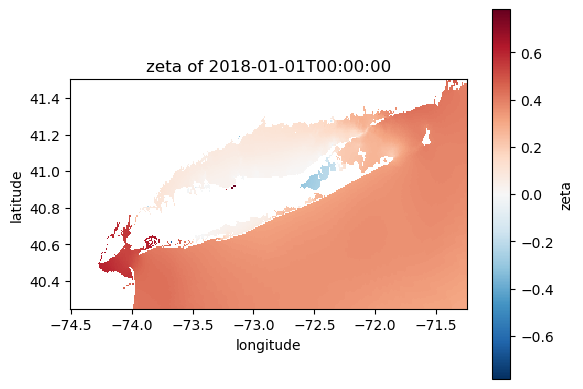

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
qm = zeta.isel(time=0).plot(ax=ax)
ax.set_aspect(1.5)
ax.set_title(f"zeta of {str(zeta.time[0].values)[:19]}")
plt.show()

## Train a neural network

Now let's train a simple convolutional neural network.

In [17]:
import os
from pathlib import Path
from collections import OrderedDict
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.__version__

# Set reproducibility seeds
torch.manual_seed(42)
np.random.seed(42)

# Priority order: CUDA > TPU > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
elif hasattr(torch, 'xla') or 'xla' in torch.__dict__:
    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
    except ImportError:
        device = torch.device("cpu")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


### PyTorch dataset


In [18]:
# Configuration aligned with the quickstart dataset
DATA_DIR = Path(data_dir)
TARGET_VAR = "zeta" 
max_lead = 1
TIME_STRIDE = max_lead 
INPUT_STEPS = 12

# Optional mask; set MASK_PATH to None to skip
MASK_PATH: Optional[Path] = DATA_DIR / "real_land_mask_180_360.nc"
MASK_VARIABLE = "mask"  # variable name inside the mask file
MASK_THRESHOLD = 0.5  # when MASK_VALID_EQUALS is None, keep values >= threshold
MASK_VALID_EQUALS: Optional[float] = 0.0  # e.g. set to 0.0 if 0 marks valid land
MASK_EQUAL_TOL = 1e-6
MASK_INVERT = False  # flip valid/invalid if your mask marks land with low values

if not DATA_DIR.exists():
    raise FileNotFoundError(f"DATA_DIR {DATA_DIR} does not exist. Adjust the path before continuing.")


In [19]:
# Open the requested period, keep only the target variable, and optionally thin the time dimension.
ds_raw = open_period(TIME_PERIOD, data_dir=DATA_DIR)
ds_raw = ensure_lat_lon_dims(ds_raw)

if TARGET_VAR not in ds_raw:
    raise KeyError(f"{TARGET_VAR!r} not found in dataset variables: {list(ds_raw.data_vars)}")

ds_raw = ds_raw[[TARGET_VAR]]

land_mask = load_land_mask(MASK_PATH, variable=MASK_VARIABLE)
if land_mask is not None:
    land_mask = land_mask.interp_like(ds_raw[TARGET_VAR], method="nearest")
    if MASK_VALID_EQUALS is not None:
        valid = np.isclose(land_mask, MASK_VALID_EQUALS, atol=MASK_EQUAL_TOL)
    else:
        valid = land_mask >= MASK_THRESHOLD
    if MASK_INVERT:
        valid = ~valid
    ds_raw[TARGET_VAR] = ds_raw[TARGET_VAR].where(valid)

if TIME_STRIDE and TIME_STRIDE > 1:
    ds_raw = ds_raw.isel(time=slice(0, None, TIME_STRIDE))

# ds_raw


In [20]:
# Derive simple train/validation/test splits from the available years.
available_years = np.unique(ds_raw.time.dt.year.values)
if available_years.size < 3:
    raise ValueError(
        "TIME_PERIOD must span at least three distinct years to create train/valid/test splits."
    )

train_years = available_years[:-2]
valid_years = available_years[-2:-1]
test_years = available_years[-1:]

if train_years.size == 0:
    raise ValueError("Extend TIME_PERIOD so that at least one year is available for training.")

# select data subsets

ds_train = subset_by_years(ds_raw, train_years)
ds_valid = subset_by_years(ds_raw, valid_years)
ds_test = subset_by_years(ds_raw, test_years)

print(f"Train years: {train_years.tolist()}")
print(f"Valid years: {valid_years.tolist()}")
print(f"Test years:  {test_years.tolist()}")
# print(ds_train[TARGET_VAR])
# print(ds_valid[TARGET_VAR])
# print(ds_test[TARGET_VAR])


Train years: [2018, 2019, 2020]
Valid years: [2021]
Test years:  [2022]


In [21]:
print(f"Train samples: {ds_train.sizes['time']}")
print(f"Valid samples: {ds_valid.sizes['time']}")
print(f"Test samples: {ds_test.sizes['time']}")


Train samples: 26304
Valid samples: 8760
Test samples: 8760


In [22]:
var_dict = OrderedDict({TARGET_VAR: None})
batch_size = 64
lead_time = max_lead  # number of index steps ahead (4 * TIME_STRIDE hours)
input_steps = INPUT_STEPS

In [23]:
#  Flattens multiple variables (and optional pressure levels) into a single channels axis.
#  Normalizes with train stats.
#  Produces pairs of (x[t], y[t+lead]) in channels-first tensors for PyTorch.
#  Exposes init_time, valid_time, etc.

train_ds = CoraDataset(
    ds_train,
    var_dict,
    lead_time,
    input_steps=input_steps,
    load_into_memory=True,
)
valid_ds = CoraDataset(
    ds_valid,
    var_dict,
    lead_time,
    input_steps=input_steps,
    mean=train_ds.mean,
    std=train_ds.std,
    load_into_memory=True,
)
test_ds = CoraDataset(
    ds_test,
    var_dict,
    lead_time,
    input_steps=input_steps,
    mean=train_ds.mean,
    std=train_ds.std,
    load_into_memory=True,
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [24]:
print(f'Train samples: {len(train_ds)} | Input channels: {train_ds.input_channels} | Output channels: {train_ds.output_channels}')
print(f'Input steps: {train_ds.input_steps} | Target lead time: {train_ds.lead_time}')

Train samples: 26292 | Input channels: 12 | Output channels: 1
Input steps: 12 | Target lead time: 1


### Create and train model

Use the PyTorch builders in `src.networks` by selecting a model kind in the next cell.
The defaults mirror the original CNN and add ResNet/UNet-style options.


In [35]:
model_kind = "resnet"  # choose from: 'cnn', 'resnet', 

# 'uresnet', 'unet', 'unet_google'

spatial_shape = train_ds.inputs.shape[-2:]
input_shape = (*spatial_shape, train_ds.input_channels)

def make_cnn():
    return NeuralCoraCNN(
        train_ds.input_channels,
        hidden_channels=[8, 32, 32, 8],
        kernel_size=5,
        out_channels=train_ds.output_channels,
        dropout=0.0,
    )

def make_resnet():
    return build_resnet(
        filters=[8,32, 32, 8, train_ds.output_channels],
        kernels=[3, 3, 3, 3, 3],
        input_shape=input_shape,
        bn_position="post",
        dropout=0.1,
        activation="relu",
    )

def make_uresnet():
    return build_uresnet(
        filters=[8, 16, 8, train_ds.output_channels],
        kernels=[3, 3, 3, 3],
        unres=[2, 2],
        input_shape=input_shape,
        bn_position="mid",
        dropout=0.1,
        activation="relu",
    )

def make_unet():
    return build_unet(
        input_shape=input_shape,
        n_layers=4,
        filters_start=4,
        channels_out=train_ds.output_channels,
        kernel=3,
        dropout=0.1,
        activation="relu",
    )

def make_unet_google():
    return build_unet_google(
        filters=[8, 16, 16, 8],
        input_shape=input_shape,
        output_channels=train_ds.output_channels,
        dropout=0.1,
    )

model_factory = {
    "cnn": make_cnn,
    "resnet": make_resnet,
    "uresnet": make_uresnet,
    "unet": make_unet,
    "unet_google": make_unet_google,
}

if model_kind not in model_factory:
    raise ValueError(f"Unknown model_kind {model_kind!r}")

model = model_factory[model_kind]().to(device)



In [36]:
model

NeuralCoraResNet(
  (relu_layer): Identity()
  (input_block): ConvBlock(
    (conv): PeriodicConv2d(
      (pad): PeriodicPad2d()
      (conv): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1))
    )
    (bn_post): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout2d(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0): ResidualBlock(
      (pool): Identity()
      (block1): ConvBlock(
        (conv): PeriodicConv2d(
          (pad): PeriodicPad2d()
          (conv): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
        )
        (bn_post): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
      (block2): ConvBlock(
        (conv): PeriodicConv2d(
          (pad): PeriodicPad2d()
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        )
        (bn_post): BatchNorm2d(3

In [37]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Model '{model_kind}' parameter count: {num_params:,}")


Model 'resnet' parameter count: 48,121


In [38]:
# Re-run this cell after creating the model to reset optimizer/scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)


In [39]:
num_epochs = 8
history = fit(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=num_epochs,
    device=device,
    valid_loader=valid_loader,
    scheduler=scheduler,
)

Epoch 1/8: train 0.0455 val 0.0122
Epoch 2/8: train 0.0195 val 0.0138
Epoch 3/8: train 0.0160 val 0.0105
Epoch 4/8: train 0.0148 val 0.0133
Epoch 5/8: train 0.0146 val 0.0081
Epoch 6/8: train 0.0136 val 0.0098
Epoch 7/8: train 0.0131 val 0.0050
Epoch 8/8: train 0.0131 val 0.0103


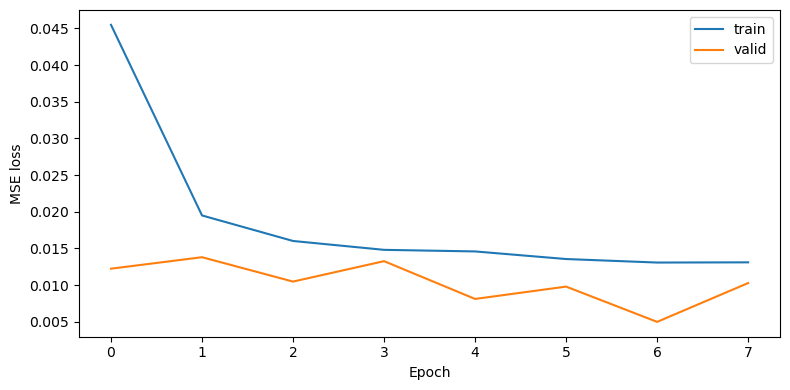

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(history['train'], label='train')
if not np.isnan(history['valid']).all():
    plt.plot(history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.tight_layout()
plt.show()

### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [41]:
predictions = create_predictions(model, test_loader, test_ds, device)

In [42]:
truth = rename_for_score(test_ds.ds[TARGET_VAR].sel(time=test_ds.valid_time))
preds_da = rename_for_score(predictions[TARGET_VAR])

rmse = compute_weighted_rmse(preds_da, truth, weights=None)
print(f"Weighted RMSE: {rmse.values.item():.4f}")


Weighted RMSE: 0.0568


### Compare predictions and truth

Visualize time-series at high-error locations (or user-selected coordinates) to inspect model performance.

- Set `comparison_coords` to a list of `(latitude, longitude)` pairs to examine specific sites.
- Adjust `time_window` (tuple of ISO timestamps) to focus on a particular period, or leave it as `None`.
- When `comparison_coords` is `None`, the top `num_points` locations by RMSE are displayed.


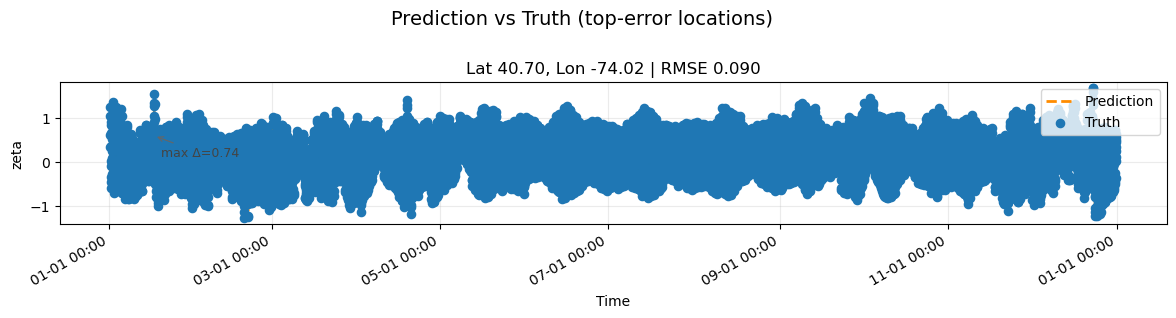

In [43]:
# Configure which grid points to plot
# comparison_coords = None  # e.g., [(30.0, -90.0)]
comparison_coords = [(40.70, -74.015)]
num_points = 0  # used when comparison_coords is None
time_window = ("2022-01-01", "2022-12-31")  # e.g., ("2022-04-01", "2022-06-01")

# Determine shared time dimension names
pred_time_dim_candidates = [dim for dim in preds_da.dims if dim in ("time", "valid_time")]
pred_time_dim = pred_time_dim_candidates[0] if pred_time_dim_candidates else preds_da.dims[0]
truth_time_dim = pred_time_dim if pred_time_dim in truth.dims else ("time" if "time" in truth.dims else truth.dims[0])

# Optional temporal focus window
if time_window:
    start_time, end_time = time_window
    preds_window = preds_da.sel({pred_time_dim: slice(start_time, end_time)})
    truth_window = truth.sel({truth_time_dim: slice(start_time, end_time)})
else:
    preds_window = preds_da
    truth_window = truth

# Align on the shared coordinates/time axis and drop missing pairs
preds_window, truth_window = xr.align(preds_window, truth_window, join="inner")

rmse_time_dim_candidates = [dim for dim in preds_window.dims if dim in ("time", "valid_time")]
rmse_time_dim = rmse_time_dim_candidates[0] if rmse_time_dim_candidates else preds_window.dims[0]
rmse_map = np.sqrt(((preds_window - truth_window) ** 2).mean(dim=rmse_time_dim))
rmse_series = rmse_map.to_series().dropna()

# Decide which sites to visualize
selected_sites = []
if comparison_coords:
    for lat, lon in comparison_coords:
        truth_pt = truth_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
        pred_pt = preds_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
        rmse_val = float(np.sqrt(((pred_pt - truth_pt) ** 2).mean(dim=rmse_time_dim).values))
        actual_lat = float(truth_pt.latitude.values) if "latitude" in truth_pt.coords else float(lat)
        actual_lon = float(truth_pt.longitude.values) if "longitude" in truth_pt.coords else float(lon)
        selected_sites.append(((actual_lat, actual_lon), rmse_val))
else:
    top_series = rmse_series.nlargest(num_points)
    selected_sites = list(top_series.items())

if not selected_sites:
    raise ValueError("No comparison locations selected. Check inputs.")

fig, axes = plt.subplots(len(selected_sites), 1, figsize=(12, 3.2 * len(selected_sites)), sharex=True)
if len(selected_sites) == 1:
    axes = [axes]

for ax, (coord, rmse_val) in zip(axes, selected_sites):
    lat, lon = coord
    truth_pt = truth_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
    pred_pt = preds_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)

    combined = xr.Dataset({
        "Truth": truth_pt,
        "Prediction": pred_pt,
    })
    df = combined.to_dataframe().reset_index()
    for col in ("latitude", "longitude", "lead_time"):
        if col in df:
            df = df.drop(columns=col)
    df = df.rename(columns={pred_time_dim: "time"})
    df = df.dropna(subset=["Truth", "Prediction"]).sort_values("time")

    if df.empty:
        ax.text(0.5, 0.5, "No overlapping timestamps", transform=ax.transAxes, ha="center", va="center")
        continue

    error = (df["Prediction"] - df["Truth"]).abs()
    ax.plot(df["time"], df["Prediction"], label="Prediction", color="#FF8C00", linewidth=2, linestyle="--")
    ax.scatter(df["time"], df["Truth"], label="Truth", color="#1f77b4", s=35, zorder=3)
    ax.plot(df["time"], df["Truth"], color="#1f77b4", linewidth=1, alpha=0.6)
    ax.fill_between(df["time"], df["Truth"], df["Prediction"], color="#1f77b4", alpha=0.12)

    max_idx = error.idxmax()
    if not error.empty:
        ax.annotate(
            f"max Δ={error.loc[max_idx]:.2f}",
            xy=(df.loc[max_idx, "time"], df.loc[max_idx, "Prediction"]),
            xytext=(5, -15),
            textcoords="offset points",
            fontsize=9,
            color="#444444",
            arrowprops=dict(arrowstyle="->", color="#666666", lw=0.8),
        )

    ax.set_title(f"Lat {lat:.2f}, Lon {lon:.2f} | RMSE {rmse_val:.3f}")
    ax.set_ylabel(TARGET_VAR)
    ax.grid(True, which="major", alpha=0.25)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))

axes[0].legend(loc="upper right")
axes[-1].set_xlabel("Time")
fig.autofmt_xdate()
fig.suptitle("Prediction vs Truth (top-error locations)", y=0.98, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### Interactive time-series comparison
Select a location from the dropdown to inspect the truth vs. prediction curves.
If `comparison_coords` is provided it drives the list; otherwise the top-RMSE sites are shown.


In [44]:
from ipywidgets import interact, widgets
import plotly.graph_objects as go

# Prefer manually supplied coordinates; otherwise reuse the automatically selected ones
if comparison_coords:
    interactive_locations = list(comparison_coords)
else:
    interactive_locations = [coords for coords, _ in selected_sites]

if not interactive_locations:
    raise ValueError("No locations available for the interactive comparison widget.")

def _prepare_timeseries(lat, lon):
    truth_pt = truth_window.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    pred_pt = preds_window.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    combined = xr.Dataset({'Truth': truth_pt, 'Prediction': pred_pt})
    df = combined.to_dataframe().reset_index().dropna()
    df = df.rename(columns={pred_time_dim: 'time'})
    return df

def _label(lat, lon):
    return f"Lat {lat:.2f}°, Lon {lon:.2f}°"

options = [( _label(lat, lon), idx) for idx, (lat, lon) in enumerate(interactive_locations)]

@interact(location=widgets.Dropdown(options=options, description='Location'))
def show_interactive(location=0):
    lat, lon = interactive_locations[location]
    df = _prepare_timeseries(lat, lon)
    if df.empty:
        fig = go.Figure()
        fig.update_layout(title=f"{_label(lat, lon)} — no overlapping timestamps", xaxis_title='Time', yaxis_title=TARGET_VAR)
        return fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['time'], y=df['Truth'], mode='lines+markers', name='Truth'))
    fig.add_trace(go.Scatter(x=df['time'], y=df['Prediction'], mode='lines+markers', name='Prediction'))
    fig.update_layout(
        title=f'Interactive Comparison | {_label(lat, lon)}',
        xaxis_title='Time',
        yaxis_title=TARGET_VAR,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    )
    fig.show()


interactive(children=(Dropdown(description='Location', options=(('Lat 40.70°, Lon -74.02°', 0),), value=0), Ou…

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.